In [53]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("dataset/resize_borvo.csv")

# Konversi ke grid dictionary
grid = {}
for _, row in df.iterrows():
    grid[(int(row["i"]), int(row["j"]))] = {"H": row["H"], "W": row["W"]}

In [54]:
# Fungsi ambil tetangga 8 arah (termasuk diagonal)
def get_all_neighbors(pos):
    i, j = pos
    directions = [
        (-1, -1), (-1, 0), (-1, 1),
        (0, -1),           (0, 1),
        (1, -1), (1, 0), (1, 1)
    ]
    neighbors = [(i + di, j + dj) for di, dj in directions]
    return [n for n in neighbors if n in grid]

# Fungsi hitung skor W/E
def get_score(current_pos, neighbor_pos):
    H1 = grid[current_pos]["H"]
    H2 = grid[neighbor_pos]["H"]
    S = H1 - H2

    if S > 0.5:
        return -np.inf  # Tidak aman → skip

    E = 1 + 1 * abs(S)
    W = grid[neighbor_pos]["W"]
    return W / E

In [55]:
# Fungsi Hill Climbing dengan Horizon (Lookahead Depth)
def hill_climbing_with_horizon(start, depth=3):
    if start not in grid:
        print(f"Titik {start} tidak ditemukan dalam dataset.")
        return []

    current = start
    path = [current]
    visited = set([start])

    def dfs(current_path, total_score, remaining_depth):
        current_node = current_path[-1]
        if remaining_depth == 0:
            return (total_score, current_path)

        best = (total_score, current_path)
        for neighbor in get_all_neighbors(current_node):
            if neighbor in current_path:
                continue
            score = get_score(current_node, neighbor)
            if score == -np.inf:
                continue
            result = dfs(current_path + [neighbor], total_score + score, remaining_depth - 1)
            if result[0] > best[0]:
                best = result
        return best

    while True:
        best_score = -np.inf
        best_path = None
        neighbors = get_all_neighbors(current)

        for neighbor in neighbors:
            if neighbor in visited:
                continue
            score = get_score(current, neighbor)
            if score == -np.inf:
                continue

            # Cari jalur terbaik dari current → neighbor (hingga depth-1)
            result_score, result_path = dfs([current, neighbor], score, depth - 1)

            if result_score > best_score:
                best_score = result_score
                best_path = result_path

        if best_path is None or best_path[1] in visited:
            break

        current = best_path[1]  # langkah pertama dari path terbaik
        path.append(current)
        visited.add(current)



    return path

In [56]:
# Titik uji coba
test_points = [
    (540/2, 648/2),
    (20/2, 502/2),
    (410//2, 915//2),
    (529, 357)
]

# Jalankan algoritma untuk semua titik uji
for idx, point in enumerate(test_points, 1):
    print(f"\n=== Titik {idx} - Start di {point} ===")
    path = hill_climbing_with_horizon(point)
    print(f"Jumlah langkah: {len(path)}")
    print("Jalur:")
    for p in path:
        print(p)


=== Titik 1 - Start di (270.0, 324.0) ===
Jumlah langkah: 188
Jalur:
(270.0, 324.0)
(270.0, 323.0)
(269.0, 322.0)
(270.0, 321.0)
(271.0, 320.0)
(270.0, 319.0)
(269.0, 319.0)
(269.0, 320.0)
(269.0, 321.0)
(270.0, 322.0)
(269.0, 323.0)
(269.0, 324.0)
(268.0, 324.0)
(268.0, 325.0)
(267.0, 326.0)
(266.0, 326.0)
(266.0, 325.0)
(267.0, 325.0)
(267.0, 324.0)
(267.0, 323.0)
(268.0, 322.0)
(267.0, 321.0)
(266.0, 321.0)
(266.0, 320.0)
(265.0, 321.0)
(264.0, 321.0)
(263.0, 322.0)
(262.0, 321.0)
(262.0, 322.0)
(263.0, 321.0)
(264.0, 320.0)
(265.0, 319.0)
(266.0, 318.0)
(267.0, 318.0)
(268.0, 317.0)
(267.0, 316.0)
(266.0, 317.0)
(265.0, 317.0)
(264.0, 317.0)
(263.0, 317.0)
(263.0, 316.0)
(263.0, 315.0)
(264.0, 316.0)
(265.0, 315.0)
(265.0, 314.0)
(266.0, 315.0)
(267.0, 315.0)
(266.0, 314.0)
(265.0, 313.0)
(266.0, 313.0)
(265.0, 312.0)
(264.0, 312.0)
(265.0, 311.0)
(265.0, 310.0)
(264.0, 309.0)
(264.0, 310.0)
(263.0, 309.0)
(264.0, 308.0)
(265.0, 308.0)
(266.0, 307.0)
(266.0, 306.0)
(266.0, 305.0)


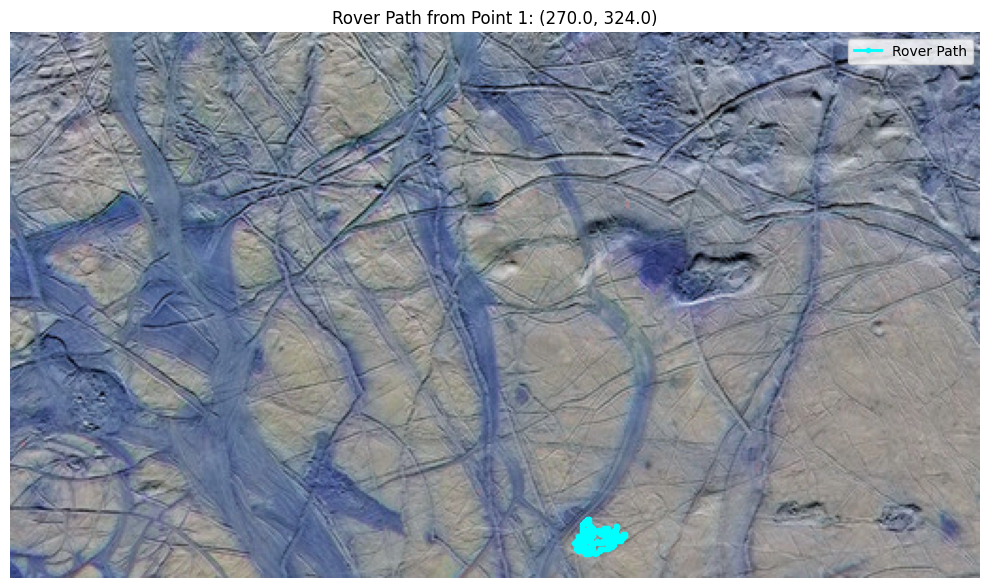

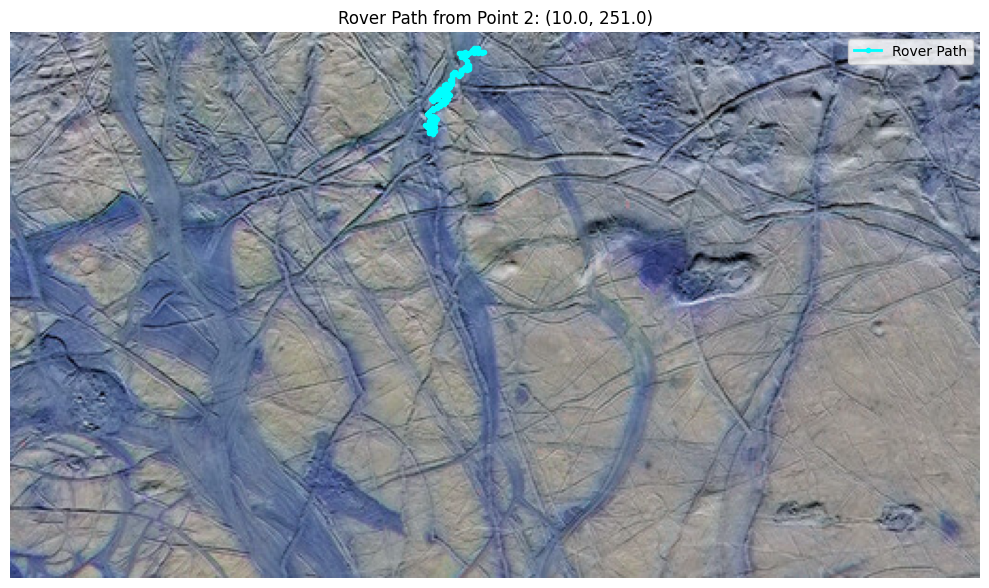

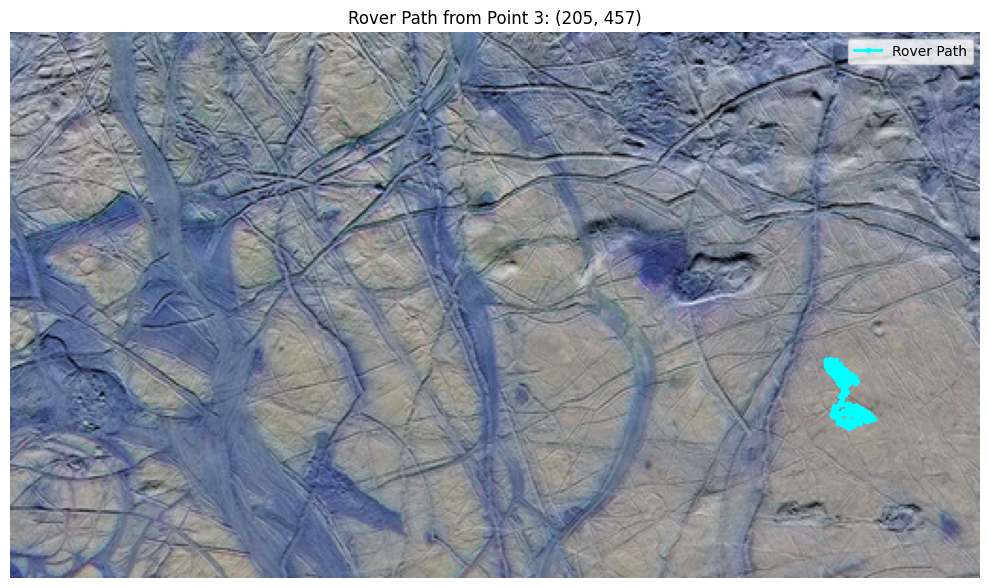

Titik (529, 357) tidak ditemukan dalam dataset.


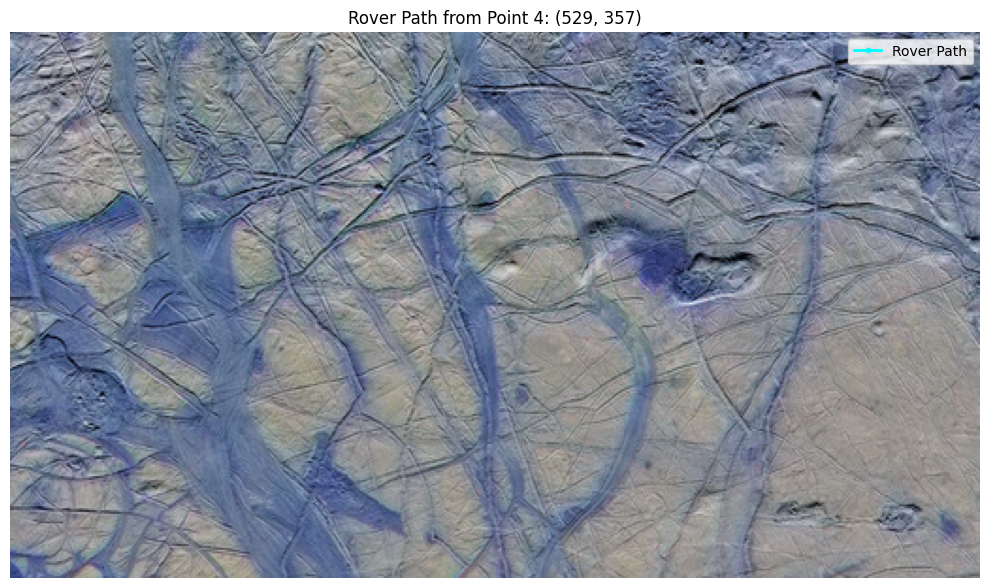

In [57]:
import matplotlib.pyplot as plt
import cv2

# Muat gambar height map dan konversi ke grayscale
img = cv2.imread("europa_map/raw/resize_borvo_mensa.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
H_map = cv2.Sobel(gray, cv2.CV_64F, 1, 1, ksize=5)  # Representasi elevasi sederhana

# Visualisasi jalur untuk semua titik uji coba
for idx, point in enumerate(test_points, 1):
    path = hill_climbing_with_horizon(point, depth=3)
    path_x = [j for i, j in path]  # j = x-axis
    path_y = [i for i, j in path]  # i = y-axis

    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.plot(path_x, path_y, color="cyan", marker="o", linewidth=2, markersize=3, label="Rover Path")
    plt.title(f"Rover Path from Point {idx}: {point}")
    plt.legend()
    plt.axis("off")
    plt.tight_layout()
    plt.show()
